In [2]:
# BEST SOLUTION EVER

# import dependencies
import os
import requests
import json
import pandas as pd
import plotly.express as px
from config import api_key
from config import mapbox_token

%reload_ext lab_black

px.set_mapbox_access_token(mapbox_token)

In [3]:
# testing out the eBird API
regionCode = "US-TX"

url = f"https://api.ebird.org/v2/data/obs/{regionCode}/recent"

r = requests.get(url, params={"key": api_key, "back": 7})

In [4]:
r.url

'https://api.ebird.org/v2/data/obs/US-TX/recent?key=d56mdhi9b35r&back=7'

In [5]:
r.status_code

200

In [6]:
data = r.json()

In [7]:
obs_df = pd.DataFrame(data)
obs_df

,speciesCode,comName,sciName,locId,locName,obsDt,howMany,lat,lng,obsValid,obsReviewed,locationPrivate,subId
0,brdowl,Barred Owl,Strix varia,L1402144,Clear Creek Village,2020-09-26 02:50,2.0,29.505039,-95.122225,True,False,True,S74062368
1,killde,Killdeer,Charadrius vociferus,L9845709,Backyard,2020-09-25 22:25,1.0,29.618946,-98.247328,True,False,True,S74059772
2,easowl1,Eastern Screech-Owl,Megascops asio,L11133282,Yard,2020-09-25 21:31,1.0,30.468287,-97.815558,True,False,True,S74058713
3,sctfly,Scissor-tailed Flycatcher,Tyrannus forficatus,L12366476,"403 Hereford Loop, Hutto US-TX 30.53522, -97.5...",2020-09-25 20:47,1.0,30.535221,-97.571523,True,False,True,S74057597
4,lesgol,Lesser Goldfinch,Spinus psaltria,L12366476,"403 Hereford Loop, Hutto US-TX 30.53522, -97.5...",2020-09-25 20:47,1.0,30.535221,-97.571523,True,False,True,S74057597
...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,gwfgoo,Greater White-fronted Goose,Anser albifrons,L284163,Galveston--Lafitte's Cove (UTC 068),2020-09-19 16:26,1.0,29.216901,-94.934902,True,False,False,S73860578
475,crow,crow sp.,Corvus sp. (crow sp.),L1918114,Collier's Ferry Park,2020-09-19 15:20,1.0,30.132133,-94.095819,True,False,False,S73795209
476,y00012,Western/Clark's Grebe,Aechmophorus occidentalis/clarkii,L457609,Red Bluff Reservoir Dam area- S. portion (Reev...,2020-09-19 15:03,12.0,31.898346,-103.916867,True,False,False,S73797953
477,budger1,Budgerigar (Domestic type),Melopsittacus undulatus (Domestic type),L12322533,"1038–1158 Pine St, Freeport US-TX 28.93966, -9...",2020-09-19 13:23,1.0,28.939655,-95.348410,True,True,True,S73787735


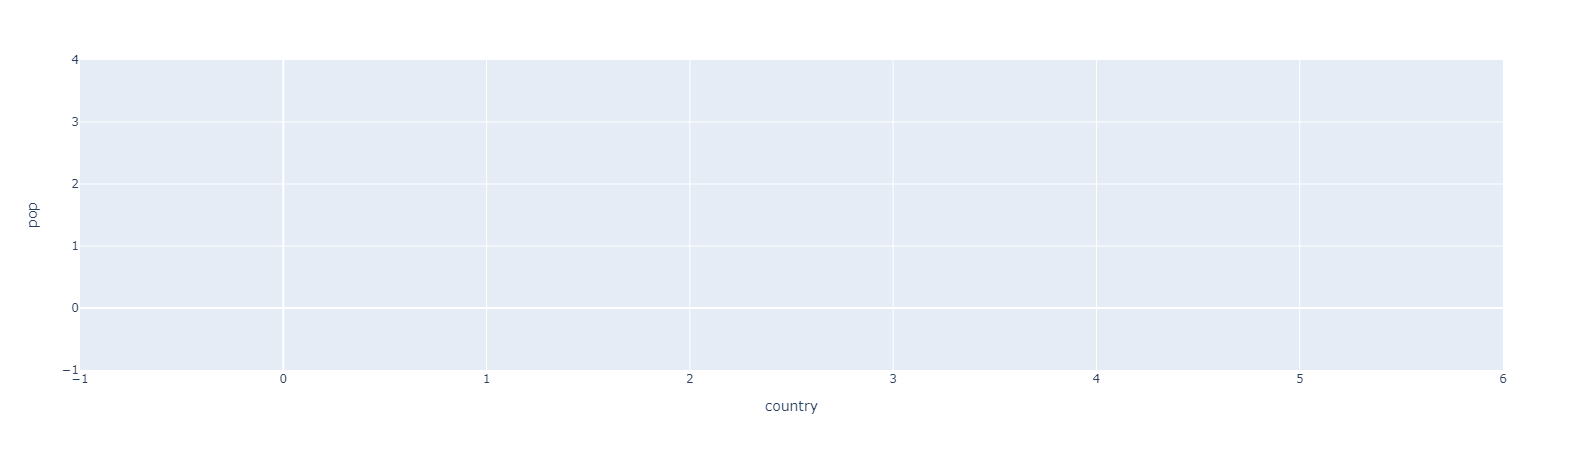

In [21]:
obs_df = px.data.gapminder().query("country == 'US'")
fig = px.bar(obs_df, x="country", y="pop")
fig.show()

In [25]:
# Looking for Historic observation dates
regionCode = "US"
Year = 2000
Month = 9
Day = 25

url = f"https://api.ebird.org/v2/data/obs/{{regionCode}}/historic/{Year}}/{Month}/{Day}"

r = requests.get(url, params={"key": api_key})
data = r.json()
df_city_names_codes = pd.DataFrame(r.json())

SyntaxError: f-string: single '}' is not allowed (<ipython-input-25-d9368bbd2920>, line 7)

In [23]:
r.url

'https://api.ebird.org/v2/data/obs/%7B%7BregionCode%7D%7D/historic/%7BYear%7D%7D/%7BMonth%7D/%7BDay%7D?key=d56mdhi9b35r'

In [24]:
r.status_code

400

In [35]:
df_city_names_codes = pd.DataFrame(r.json())
df_city_names_codes

,errors
0,"{'status': '400 BAD_REQUEST', 'code': 'typeMis..."
1,"{'status': '400 BAD_REQUEST', 'code': 'typeMis..."
2,"{'status': '400 BAD_REQUEST', 'code': 'typeMis..."


In [28]:
# find number of species logged in different Texas cities for the last week

# first make the list of Texas cities to search
# city-level region codes for Texas are stored in df["code"]
df_city_names_codes["code"].head()

0    US-SC-001
1    US-LA-001
2    US-VA-001
3    US-ID-001
4    US-IA-001
Name: code, dtype: object

In [23]:
# make them into a list to iterate over for later
cities = df["code"].to_list()

# here's the first city in the list:
cities[0]

'US-SC-001'

In [ ]:
# for a city, find the number of bird species observed in the last 7 days
regionCode = cities[3]
num_days = 7

url = "https://api.ebird.org/v2/data/obs/" + regionCode + "/recent"

df_city = pd.DataFrame(
    requests.get(url, params={"key": api_key, "back": num_days}).json()
)

df_city.head()

In [ ]:
# number of bird species observed is done by counting unique speciesCode
df_city["speciesCode"].nunique()

In [ ]:
# can do this all at once for a given city:
pd.DataFrame(requests.get(url, params={"key": api_key, "back": num_days}).json())[
    "speciesCode"
].nunique()

In [ ]:
# now iterate over all the cities in the cities list to get a count of species observed in Texas cities for the last 7 days
num_days = 7

num_observations = []
no_observations = []

for city in cities:
    url = "https://api.ebird.org/v2/data/obs/" + city + "/recent"
    try:
        num_observations.append(
            pd.DataFrame(
                requests.get(url, params={"key": api_key, "back": num_days}).json()
            )["speciesCode"].nunique()
        )
    except Exception as e:
        no_observations.append(city)
        num_observations.append(0)

In [ ]:
# getting a list of sub-region codes (subnational1 for US is a list of states, subnational2 for US-TX is a list of cities)
regionType = "subnational2"
parentRegionCode = "US"

url = (
    "https://api.ebird.org/v2/ref/region/list/"
    + regionType
    + "/"
    + parentRegionCode
    + ".json"
)

r = requests.get(url, params={"key": api_key})


## MORE THOUGHTS:
* can keep going... merge the city name back into the new dataframe
* use request to get open weather map data for the cities (if possible going back 7 days ... may need a different weather API to see past weather data)
* could compare number of observations to temp / weather type (sunny, windy, rainy)
* use Google geocoding API to map cities to lat/lon and put number of sightings on map using plotly
* make a bar chart to show which species observed most often across the state
* probably need to actually store the results as they are requested instead of just extracting out individual pieces of info
* eBirds also has "notable" observations request which returns rare birds or unusual observations - could be fun to request a list of "notable" sightings for Austin for the last X days
* needs to be more robust generally, but this is the skeleton of the idea